# Cox models: Advanced

In this notebook we will train a Cox-Time model. For more basic usage see the cox_models_introduction.ipynb notebook.
We need to stress that the choices made here doesn't necessarily result in the best model, but are instead intended to illustrate what this python package can do.

We will here fit a Cox-Time model to the SUPPORT data set

- Using entity embeddings for categorical variables.
- Use the [AdamWR optimizer](https://arxiv.org/pdf/1711.05101.pdf) with cyclical learning rates.
- Use the scheeme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from pycox import datasets
from pycox.models import CoxTime
from pycox.evaluation import EvalSurv
from torchtuples import tuplefy, optim
from torchtuples import callbacks as cb
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.preprocessing.label_transforms import LabTransCoxTime
from torchtuples.practical import MixedInputMLP
from pycox.models.cox.cox_cc import LossCoxCC

`sklearn_pandas` can be installed with `! pip install sklearn-pandas`

In [2]:
np.random.seed(123456)
_ = torch.manual_seed(123456)

## Dataset

We load the SUPPORT data set and split in train, test and validation.

In [3]:
df_train = datasets.support.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,1527.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1
5,49.932980,0.0,1.0,1.0,0.0,0.0,0.0,70.0,105.0,33.0,38.195309,127.0,5.299805,1.199951,50.0,1
6,62.942989,0.0,5.0,2.0,1.0,0.0,1.0,116.0,130.0,35.0,38.195309,133.0,14.099609,0.799927,381.0,0


## Feature transforms
We have 14 covariates, in addition to the durations and event indicators.

We will standardize the 8 numerical covariates, and leave the 4 binary variables as is. 
The 3 categorical variables will be transformed to `int64` integers giving the category. The category 0 is reserved for `None` and very small categories that are set to `None`. 

In [5]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [6]:
x_fit_transform = lambda df: tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [7]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In [8]:
x_train.shapes()

((5678, 11), (5678, 3))

In [9]:
x_train.dtypes()

(dtype('float32'), dtype('int64'))

## Label transforms

The targets (durations and events) also needs to be arrays of type `'float32'`.
We log-transform the durations before we standardize. Labeltransforms are only necessary for Cox-Time and non-of the other Cox methods.

In [10]:
get_target = lambda df: (df['duration'].values.astype('float32'), df['event'].values.astype('float32'))
labtrans = LabTransCoxTime(log_duration=True)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tuplefy(x_val, y_val)

## Neural net

We make a torch net. If this is new to you, we would recommend [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following is an extension of the `torchtuples.practical.MixedInputMLP` so that it works with CoxTime.
By mixed input we refer to that we have both entity embeddings and regular numerical covariates.

In [11]:
class MixedInputMLPCoxTime(torch.nn.Module):
    def __init__(self, in_features, num_embeddings, embedding_dims, num_nodes,
                 batch_norm=True, dropout=None):
        super().__init__()
        in_features = in_features + 1
        out_features = 1
        self.net = MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes,
                                 out_features, batch_norm, dropout, output_bias=False)

    def forward(self, x_numeric, x_categoric, t):  # need an extra intput for the duration t
        x_numeric = torch.cat([x_numeric, t], dim=1)
        return self.net(x_numeric, x_categoric)

We make embeddings half the size of the number of categories.

In [12]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [13]:
num_embeddings, embedding_dims

(array([8, 7, 4]), array([4, 3, 2]))

In [14]:
in_features = x_train[0].shape[1]
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.1
net = MixedInputMLPCoxTime(in_features, num_embeddings, embedding_dims, num_nodes, batch_norm, dropout)

In [15]:
net

MixedInputMLPCoxTime(
  (net): MixedInputMLP(
    (embeddings): EntityEmbeddings(
      (embeddings): ModuleList(
        (0): Embedding(8, 4)
        (1): Embedding(7, 3)
        (2): Embedding(4, 2)
      )
    )
    (mlp): MLPVanilla(
      (net): Sequential(
        (0): DenseVanillaBlock(
          (linear): Linear(in_features=21, out_features=32, bias=True)
          (activation): ReLU()
          (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.1)
        )
        (1): DenseVanillaBlock(
          (linear): Linear(in_features=32, out_features=32, bias=True)
          (activation): ReLU()
          (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.1)
        )
        (2): DenseVanillaBlock(
          (linear): Linear(in_features=32, out_features=32, bias=True)
          (activation): ReLU()
          (batch_norm): BatchNorm1d

## Fitting model

We make an AdamWR optimizer where we multiply the learning rate wtih 0.8 at the start of every cycle. We also add shrinkage (see Cox-Time paper) of 0.01

In [16]:
optimizer = optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8)
model = CoxTime(net, optimizer, shrink=0.01)

We can use `lr_finder` to find a suitable initial learning rate. This method also sets the learning rate for the net.

0.07390722033525823

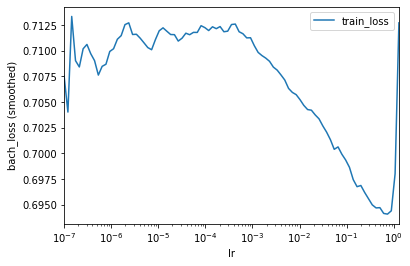

In [17]:
batch_size = 256
n_control = 1  # Number of sampled controls (see Cox-Time paper)
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=1)
lrfind.plot()
lrfind.get_best_lr()

In [18]:
model.optimizer.param_groups[0]['lr']

0.07390722033525823

We have found that `get_best_lr` sometimes gives a little high learning rate, so  we instead set it to 0.01

In [19]:
model.optimizer.set_lr(0.01)
model.optimizer.param_groups[0]['lr']

0.01

As we have introduced shrinkage to the loss function, we also want to monitor the negative log-likelihood (nll) duraing trainig. We can add this to metrics.

For early stopping, we will use a callback that will stop at the end of the cycle if the current best model was not obtained in the current cycle.
We use the negative log-likelihood of the validation set for early stopping.

In [20]:
epochs = 512
metrics = {'nll': LossCoxCC()}
callbacks = [cb.EarlyStoppingCycle(metric='nll', min_delta=0.001)]
verbose = False # set to True if you want printout

In [21]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(4).cat(), metrics=metrics)

CPU times: user 1min 32s, sys: 13.8 s, total: 1min 46s
Wall time: 43.7 s


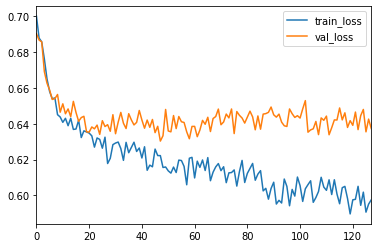

In [22]:
_ = log.to_pandas()[['train_loss', 'val_loss']].plot()

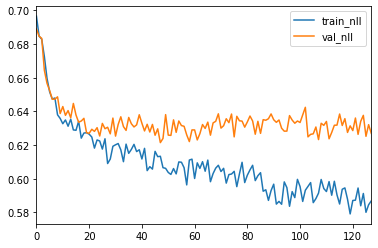

In [23]:
_ = log.to_pandas()[['train_nll', 'val_nll']].plot()

In [24]:
_ = model.compute_baseline_hazards()

In [25]:
surv = model.predict_survival_function(x_test)
surv.index = labtrans.map_scaled_to_orig(surv.index)

In [26]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [27]:
ev.concordance_td()

0.6270606965519134

In [28]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.integrated_brier_score(time_grid)

0.19113983848318378

In [29]:
ev.integrated_mbll(time_grid)

-0.56312244733674